Imports

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.preprocessing import normalize
from scipy.special import expit as sigmoid
import sklearn.metrics as metrics

Data loading and preprocessing

In [53]:
csv_path = "/home/jens/masterRepo/test/dataset/analysis_of_tp_and_fp_5.000000_5.000000.csv"
df = pd.read_csv(csv_path, dtype = {"objName":"category"})
df["visibleInlierFrac"] = df["visibleInliers"]/df["visiblePoints"]
df["visiblePointsFrac"] = df["visiblePoints"]/df["objectPoints"]
df["penetration"] = df[["penetrationInternal","penetrationExternal"]].max(axis=1)
df["intersectingInliers"] = df[["intersectingInliersInternal","intersectingInliersExternal"]].max(axis=1)
df["inCollision"] = df[["inCollisionInternal","inCollisionExternal"]].max(axis=1)
df["intersectingInliersFrac"] = df["intersectingInliers"] / df["visibleInliers"]
df["intersectingInliersInternalFrac"] = df["intersectingInliersInternal"] / df["visibleInliers"]

tuned_thresholds = {"AngleTubes" : 23.5,
                    "Conrods" : 15.0,
                    "Ears" : 16.0,
                    "Gameboys" : 35.5}

for tt in tuned_thresholds:
    d = df[df["objName"]==tt]
    print(tt,metrics.classification_report(d.g.values,d.score.values>tuned_thresholds[tt],output_dict=True)['1']["f1-score"])

indexes = np.zeros(df.shape[0])
for tt in tuned_thresholds:
    indexes = np.logical_or(indexes,df.score.values>tuned_thresholds[tt])

df_t = df[indexes]
df_c = df[df["inCollision"]==1]
df_cn = df[df["inCollision"]==0]
df.head()

AngleTubes 0.807061790668348
Conrods 0.44496487119437944
Ears 0.5465116279069767
Gameboys 0.6399999999999999


,objName,dpI,gI,g,score,visiblePoints,visibleInliers,inCollisionInternal,inCollisionExternal,penetrationInternal,...,intersectingInliersInternal,intersectingInliersExternal,objectPoints,visibleInlierFrac,visiblePointsFrac,penetration,intersectingInliers,inCollision,intersectingInliersFrac,intersectingInliersInternalFrac
0,AngleTubes,0,0,1,56.9764,1668,1317,0,0,0.0,...,0,0,5051,0.789568,0.330232,0.000000,0,0,0.000000,0.000000
1,AngleTubes,0,1,1,55.1934,1728,1256,1,0,0.0,...,1,0,5051,0.726852,0.342110,0.125520,1,1,0.000796,0.000796
2,AngleTubes,0,2,1,53.7115,1754,1220,0,0,0.0,...,0,0,5051,0.695553,0.347258,0.000000,0,0,0.000000,0.000000
3,AngleTubes,0,3,1,51.1050,1769,1275,1,0,0.0,...,0,0,5051,0.720746,0.350228,0.572053,0,1,0.000000,0.000000
4,AngleTubes,0,4,1,49.9980,1601,1177,1,0,0.0,...,0,0,5051,0.735166,0.316967,0.661725,0,1,0.000000,0.000000


Logistic Regression on Individual Pr Object factors

In [54]:

def makeList(obj):
    if type(obj) is not list:
        obj = [obj]
    return obj
def get_data_for_logistic_regression(df,objects,factors,normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    obj_df = df[df["objName"].isin(objects)]
    X = obj_df[factors].values
    if len(X.shape)==1:
        X = np.expand_dims(X,axis=1)
    if normalize_factors:
        X = normalize(X,axis=0,norm="max")

    y = np.expand_dims(obj_df.g.values,axis=1)

    return X, y

def binary_logistic_regession_individual_factors(df,objects = ["AngleTubes","Ears","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    models = {}
    result_dict = {"objName":[],"factor":[],"accuracy":[],"precision":[],"recall":[],"f1":[],"n_posetives":[],"n_negatives":[]}
    for obj in objects:
        for factor in factors:
            X,y = get_data_for_logistic_regression(df,obj,factor,normalize_factors)
            model = LogisticRegressionCV(solver='newton-cg', random_state=42).fit(X, y)
            models[obj+":"+factor] = model
            classification_report = metrics.classification_report(y,model.predict(X),output_dict=True)
            result_dict["objName"].append(obj)
            result_dict["factor"].append(factor)
            result_dict["accuracy"].append(classification_report["accuracy"])
            result_dict["precision"].append(classification_report["1"]["precision"])
            result_dict["recall"].append(classification_report["1"]["recall"])
            result_dict["f1"].append(classification_report["1"]["f1-score"])
            result_dict["n_posetives"].append(classification_report["1"]["support"])
            result_dict["n_negatives"].append(classification_report["0"]["support"])
    
    result_df = pd.DataFrame(result_dict)

    return models, result_df

def binary_logistic_regession(df,objects = ["AngleTubes","Ears","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    models = {}
    result_dict = {"objName":[],"accuracy":[],"precision":[],"recall":[],"f1":[],"n_posetives":[],"n_negatives":[]}
    for factor in factors:
        result_dict[factor+"_w"]=[]
    result_dict["intercept"]=[]

    for obj in objects:
        X,y = get_data_for_logistic_regression(df,obj,factors,normalize_factors)
        model = LogisticRegressionCV(solver='newton-cg', random_state=42).fit(X, y)
        models[obj] = model
        classification_report = metrics.classification_report(y,model.predict(X),output_dict=True)
        result_dict["objName"].append(obj)
        result_dict["accuracy"].append(classification_report["accuracy"])
        result_dict["precision"].append(classification_report["1"]["precision"])
        result_dict["recall"].append(classification_report["1"]["recall"])
        result_dict["f1"].append(classification_report["1"]["f1-score"])
        result_dict["n_posetives"].append(classification_report["1"]["support"])
        result_dict["n_negatives"].append(classification_report["0"]["support"])
        for factor,coef in zip(factors,model.coef_[0]):
            result_dict[factor+"_w"].append(coef)
        result_dict["intercept"].append(model.intercept_[0])

    result_df = pd.DataFrame(result_dict)

    return models, result_df



def logistic_regression_plots_individual_factors(df,object_names = ["AngleTubes","Ears","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    n_objects = len(object_names)
    n_factors = len(factors)
    models = {}
    fig, axes = plt.subplots(n_factors,n_objects,figsize=(n_objects*5,n_factors*5))
    for ax_row,factor in zip(axes,factors):
        for ax, obj in zip(ax_row,object_names):
            obj_df = df[df["objName"]==obj]
            X = np.expand_dims(obj_df[factor].values,axis=1)
            if(normalize_factors):
                X = normalize(X,axis=0,norm="max")

            y = np.expand_dims(obj_df.g.values,axis=1)
            model = LogisticRegressionCV(solver='newton-cg', random_state=42).fit(X, y)
            models[obj+":"+factor] = model
            y_pred = model.predict(X)

            cm =  metrics.confusion_matrix(y,y_pred)
            X_transformed = X.dot(model.coef_.T) + model.intercept_

            sigmoid_x = np.linspace(np.min(X_transformed,axis=0), np.max(X_transformed,axis=0), 500)
            sigmoid_y = sigmoid(sigmoid_x).ravel()
            ax.plot(sigmoid_x, sigmoid_y, color='red', linewidth=3)
            ax.scatter(X_transformed, y,c=y,cmap=mpl.colors.ListedColormap(["C0","C1"]),alpha=0.1,edgecolors=None,marker='s')

            ax.axvline(x=0, ymin=0, ymax=1,ls='--',alpha=0.75,color="C2")
            ax.set_ylabel("$\sigma$")
            ax.set_xlabel(factor)
            ax.set_title("{0}, Acc {1:.3f} F1 {2:.3f}".format(obj,metrics.accuracy_score(y,y_pred),metrics.f1_score(y,y_pred)))

    return fig,axes

def logistic_regression_plots(df,object_names = ["AngleTubes","Ears","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac","penetrationInternal","intersectingInliersFrac"],normalize_factors=True):
    n_objects = len(object_names)
    n_factors = len(factors)
    fig, axes = plt.subplots(1,n_objects,figsize=(n_objects*5,5))
    fig.suptitle("Linear Combination of: {}".format(factors), fontsize=16)
    for ax, obj in zip(axes,object_names):
        obj_df = df[df["objName"]==obj]
        X = obj_df[factors].values
        if(normalize_factors):
            X = normalize(X,axis=0,norm="max")

        y = np.expand_dims(obj_df.g.values,axis=1)
        model = LogisticRegressionCV(solver='newton-cg', random_state=0).fit(X, y)
        y_pred = model.predict(X)

        cm =  metrics.confusion_matrix(y,y_pred)
        X_transformed = X.dot(model.coef_.T) + model.intercept_

        sigmoid_x = np.linspace(np.min(X_transformed,axis=0), np.max(X_transformed,axis=0), 500)
        sigmoid_y = sigmoid(sigmoid_x).ravel()
        ax.plot(sigmoid_x, sigmoid_y, color='red', linewidth=3)
        ax.scatter(X_transformed, y,c=y,cmap=mpl.colors.ListedColormap(["C0","C1"]),alpha=0.1,edgecolors=None,marker='s')

        ax.axvline(x=0, ymin=0, ymax=1,ls='--',alpha=0.75,color="C2")
        ax.set_ylabel("$\sigma$")
        # ax.legend(["Decision Function","Decision threshold"])
        ax.set_title("{0}, Acc {1:.3f} F1 {2:.3f}".format(obj,metrics.accuracy_score(y,y_pred),metrics.f1_score(y,y_pred)))

    return fig,axes

def print_tuning_params(result_df,variables):
    for index,row in result_df.iterrows():
        for v in variables:
            print(row["objName"],"LR",v+"_w",row[v+"_w"],sep=",")
        print(row["objName"],"LR","intercept",row["intercept"],sep=",")     

## Logistic Regression on Individual Pr Object factors

In [55]:
variables = ["score","visibleInlierFrac","visiblePointsFrac"]
models, result_df = binary_logistic_regession_individual_factors(df,["AngleTubes","Ears","Gameboys"],variables,normalize_factors=False)
result_df

,objName,factor,accuracy,precision,recall,f1,n_posetives,n_negatives
0,AngleTubes,score,0.737500,0.747549,0.873926,0.805812,349,211
1,AngleTubes,visibleInlierFrac,0.732143,0.746898,0.862464,0.800532,349,211
2,AngleTubes,visiblePointsFrac,0.707143,0.703297,0.916905,0.796020,349,211
3,Ears,score,0.777372,0.692308,0.253521,0.371134,71,203
4,Ears,visibleInlierFrac,0.817518,0.684211,0.549296,0.609375,71,203
5,Ears,visiblePointsFrac,0.740876,0.000000,0.000000,0.000000,71,203
6,Gameboys,score,0.743455,0.743590,0.426471,0.542056,68,123
7,Gameboys,visibleInlierFrac,0.685864,0.595238,0.367647,0.454545,68,123
8,Gameboys,visiblePointsFrac,0.643979,0.000000,0.000000,0.000000,68,123


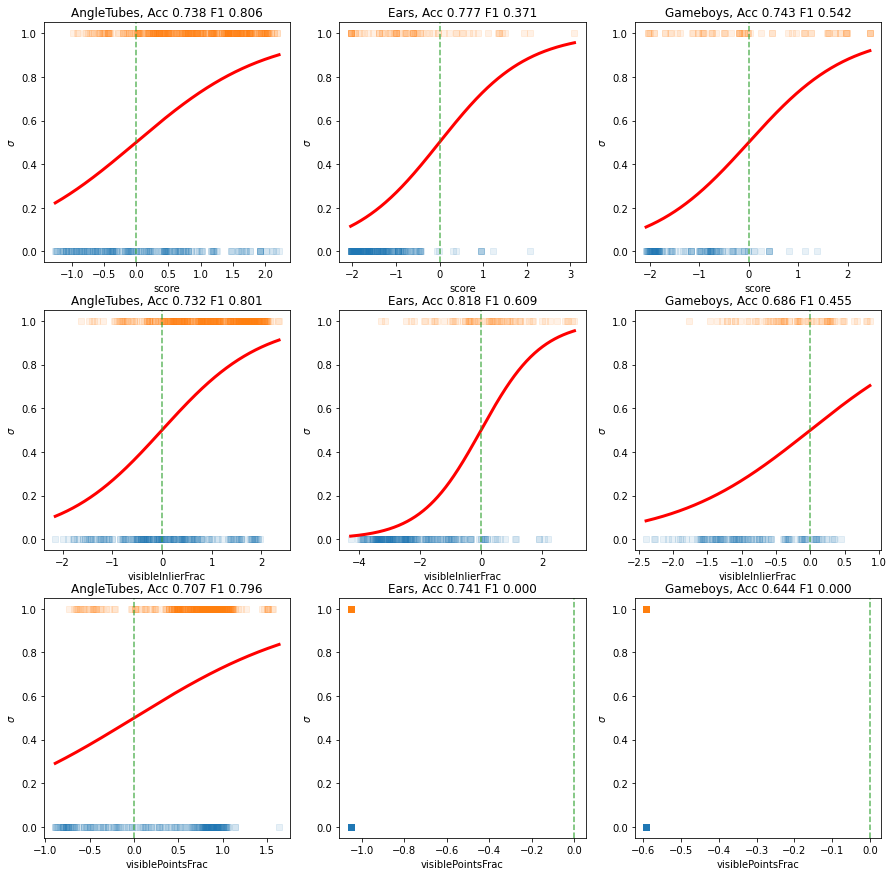

In [56]:
logistic_regression_plots_individual_factors(df,object_names = ["AngleTubes","Ears","Gameboys"], factors= ["score","visibleInlierFrac","visiblePointsFrac"],normalize_factors=False)
plt.savefig("PrObjectLogisticRegressionIndividual.pdf")
plt.savefig("PrObjectLogisticRegressionIndividual.png")
plt.show()

## Logistic Regression on Linear combination of Pr Object factors

In [57]:
models, result_df = binary_logistic_regession(df,["AngleTubes","Ears","Gameboys"],["score","visiblePointsFrac","visibleInlierFrac"],normalize_factors=False)
result_df

,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visiblePointsFrac_w,visibleInlierFrac_w,intercept
0,AngleTubes,0.748214,0.775132,0.839542,0.806052,349,211,0.047870,10.627260,3.875018,-6.744399
1,Ears,0.824818,0.682540,0.605634,0.641791,71,203,0.052659,9.264337,6.478532,-10.316525
2,Gameboys,0.774869,0.755102,0.544118,0.632479,68,123,0.055465,6.419216,3.667432,-7.851713


In [58]:
print_tuning_params(result_df,variables)

AngleTubes,LR,score_w,0.04787022127058048
AngleTubes,LR,visibleInlierFrac_w,3.875018280668015
AngleTubes,LR,visiblePointsFrac_w,10.627260467664458
AngleTubes,LR,intercept,-6.744398799402458
Ears,LR,score_w,0.05265908077663907
Ears,LR,visibleInlierFrac_w,6.4785324690919195
Ears,LR,visiblePointsFrac_w,9.264337474913594
Ears,LR,intercept,-10.31652475022017
Gameboys,LR,score_w,0.055464931157298517
Gameboys,LR,visibleInlierFrac_w,3.6674320958744984
Gameboys,LR,visiblePointsFrac_w,6.419215960538519
Gameboys,LR,intercept,-7.8517130356985305


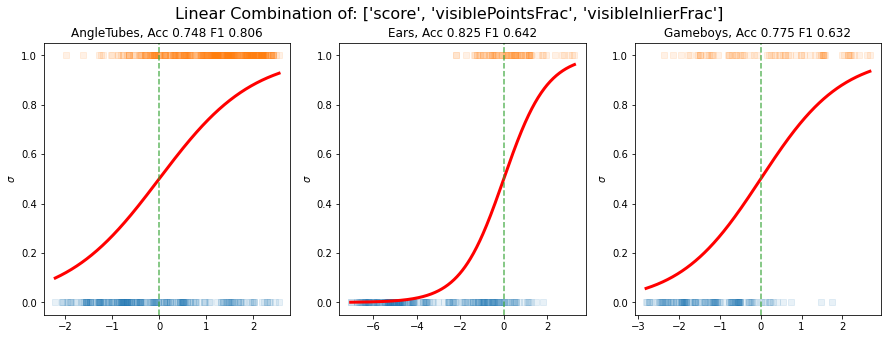

In [59]:
logistic_regression_plots(df,object_names = ["AngleTubes","Ears","Gameboys"], factors= ["score","visiblePointsFrac","visibleInlierFrac"],normalize_factors=False)
plt.savefig("PrObjectLogisticRegression.pdf")
plt.savefig("PrObjectLogisticRegression.png")
plt.show()

## Logistic Regression on Linear combination of Pr Object factors and Global factors

In [68]:
variables = ["score","visiblePointsFrac","visibleInlierFrac","intersectingInliersFrac"]
models, result_df = binary_logistic_regession(df,["AngleTubes","Ears","Gameboys"],variables,normalize_factors=False)
result_df

,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,intersectingInliersFrac_w,intercept
0,AngleTubes,0.741071,0.751232,0.873926,0.807947,349,211,0.076186,-9.682022,-2.014984
1,Ears,0.828467,0.750000,0.507042,0.605042,71,203,0.171856,-13.694399,-3.114670
2,Gameboys,0.801047,0.788462,0.602941,0.683333,68,123,0.074852,-8.126685,-2.406955


In [61]:
result_df[[s+"_w" for s in variables]+["intercept"]].mean()

score_w                       0.066137
visiblePointsFrac_w           9.351429
visibleInlierFrac_w           4.229900
intersectingInliersFrac_w   -14.583436
intercept                    -7.465188
dtype: float64

In [62]:
print_tuning_params(result_df,variables)

AngleTubes,LR,score_w,0.048195723240592396
AngleTubes,LR,visiblePointsFrac_w,17.87730086853924
AngleTubes,LR,visibleInlierFrac_w,2.6714881424173416
AngleTubes,LR,intersectingInliersFrac_w,-18.18925340163194
AngleTubes,LR,intercept,-8.223178337323496
Ears,LR,score_w,0.08810999431074208
Ears,LR,visiblePointsFrac_w,9.460827871792713
Ears,LR,visibleInlierFrac_w,8.125652141302151
Ears,LR,intersectingInliersFrac_w,-21.81845644100044
Ears,LR,intercept,-10.524985474785566
Gameboys,LR,score_w,0.062103841000709155
Gameboys,LR,visiblePointsFrac_w,0.7161572976148836
Gameboys,LR,visibleInlierFrac_w,1.8925598565880402
Gameboys,LR,intersectingInliersFrac_w,-3.7425986304713232
Gameboys,LR,intercept,-3.6474015896562664


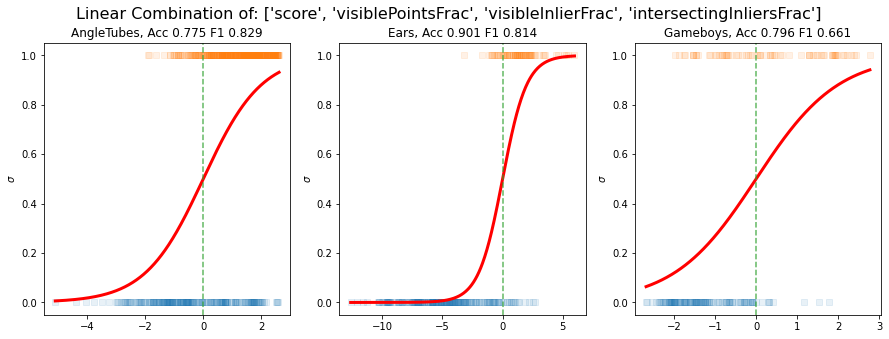

In [63]:
logistic_regression_plots(df,object_names = ["AngleTubes","Ears","Gameboys"], factors= variables,normalize_factors=False)
plt.savefig("PrObjectLogisticRegressionWGlobalInfo.pdf")
plt.savefig("PrObjectLogisticRegressionWGlobalInfo.png")
plt.show()